In [1]:
import numpy as np

## 训练二元分类器

In [2]:
data_path = './mnist_data/mnist.npz'
f = np.load(data_path)
X_train, y_train = f['x_train'], f['y_train']
X_test, y_test = f['x_test'], f['y_test']

### 数字 5 检测器

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [28]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [29]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [30]:
some_digit = X_train[0]

sgd_clf.predict([some_digit])

array([ True])

In [31]:
y_train[0]

5

数字 5 检测器验证正确！

## 性能测量

### 使用交叉验证测量准确率

In [57]:
from sklearn.model_selection import cross_val_score

# k折交叉验证，验证数字 5分类器的准确率
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.97445, 0.9745 , 0.96985])

我们使用 DummyClassifier 来看看不是5的分类情况

In [33]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
any(dummy_clf.predict(X_train))

False

In [59]:
# 基准分类器也有 90% 以上的准确率
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

由此可见，不能只看准确率

### 混淆矩阵

In [62]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict 同样执行 K-折交叉验证，但返回的不是评估分数，而是每个折叠的预测
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53822,   757],
       [  867,  4554]])

In [38]:
y_train_prefect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 准确率和召回率

In [40]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.85746563735643

In [41]:
# computes the precision: TP / (FP + TP)
cm[1,1] / (cm[0,1] + cm[1,1])

0.85746563735643

In [42]:
recall_score(y_train_5, y_train_pred)

0.8400664084117322

In [43]:
# computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.8400664084117322

In [44]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.8486768542676109

In [45]:
# computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.8486768542676109

### 准确率和召回率 trade-off

In [49]:
# 返回每个实例的分数
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([0.35044789])

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

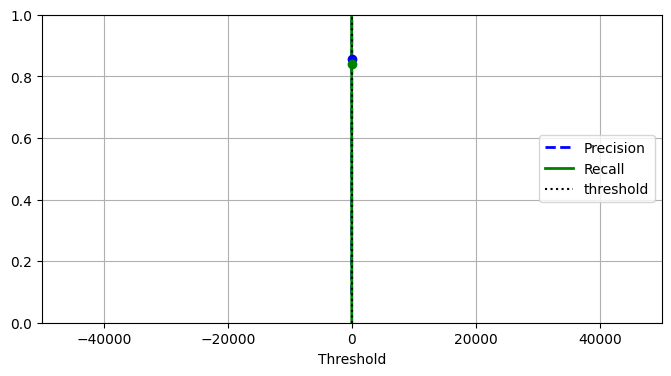

In [66]:
import matplotlib.pyplot as plt

threshold = 0.0001
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

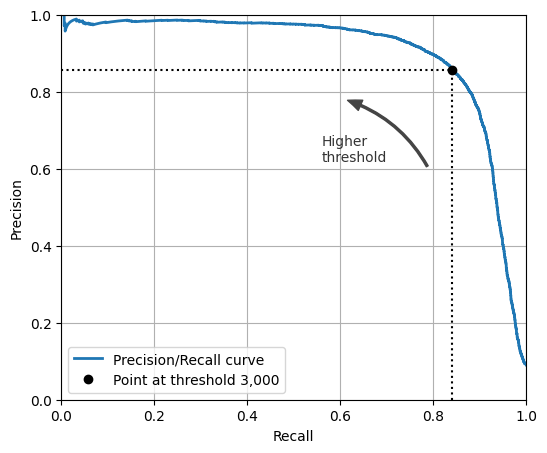

In [68]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [69]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

0.38069263198940523

In [70]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [71]:
precision_score(y_train_5, y_train_pred_90)

0.9000418235048097

In [72]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.7939494558199595